# Physical Modelling 2
- Transverse Wave
- Can reduce spatial resolution
- 

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from IPython.display import Audio
from scipy.io.wavfile import write
from datetime import datetime
import subprocess

In [34]:
def get_interpolated(array, index):
    if not hasattr(index, "__len__") or len(index) < 1: return array # if scalar
    return (1 - (index[0] % 1)) * get_interpolated(array[int(np.floor(index[0]))], index[1:]) + (index[0] % 1) * get_interpolated(array[int(np.ceil(index[0]))], index[1:])

In [35]:
get_interpolated(np.array([[1, 2],[3, 4]]), [0.5])

array([2., 3.])

# Simulation

In [36]:
import simulation

n = 128
sim_speed = 0.004
sim_fps = 400
duration = 6
frame_amount = duration * sim_fps

initial_state = np.array([[simulation.gaussian(x, y, n, offset=[-0.6, 0.0], width=0.15, height=0.15) for x in range(n)] for y in range(n)])
potential = np.array([[simulation.parabola(x, y, n, offset=(0, 0), factor=(10000, 10000)) for x in range(n)] for y in range(n)])

barrier_x = n//2 - 1
barrier_width = 2
multi_slit = [(-15, -13), (-8, -6), (-1, 1), (6, 8), (13, 15)]
double_slit = [(-4, -2), (2, 4)]
single_slit = [(-2, 2)]
slits = double_slit

frames = simulation.sim(n, sim_fps, duration, slits, barrier_x, barrier_width, sim_speed, initial_state=initial_state, potential=potential, normalize=False)

# Video

video saved as output/simulation_2024_04_23-10_56_05.mp4


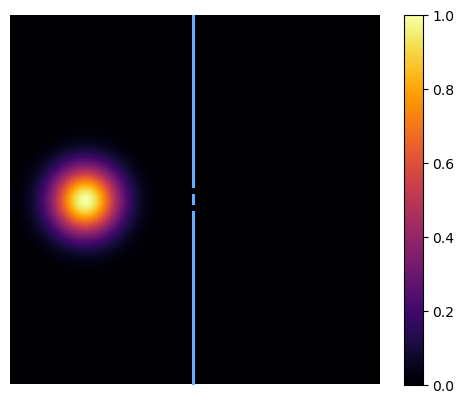

In [38]:
import video

# save video
video_filename, anim = video.create(frames, 20, 1, frame_amount, sim_fps, slits, barrier_x, barrier_width, n)

#plt.close()

# Sonification

In [68]:
average_listening = lambda array: np.average(array)
point_listening = lambda array: array[20, 60]

scaling_none = lambda deflections, data: deflections
scaling_data = lambda deflections, data: deflections * np.abs(data)

In [80]:
sample_rate = 4 * 44100 # 176000

listening = average_listening
scaling = scaling_data
excitement_point = np.array([64, 28])

dampening_per_second = 0.9 # 1 - 1e-3
spring_strength = sample_rate * 600
min_mass = 1 # 0.01 #0.00125
max_mass = 0.01 # 1 #3.2

spatial_step = 4

sonification_duration = duration

sonification_duration = np.min([duration, sonification_duration]).astype(int)
dampening_per_sample = 1 - pow(1 - dampening_per_second, 1 / sample_rate)
m = n // spatial_step
excitement_point = excitement_point // spatial_step
num_simulated_steps = sonification_duration * sample_rate

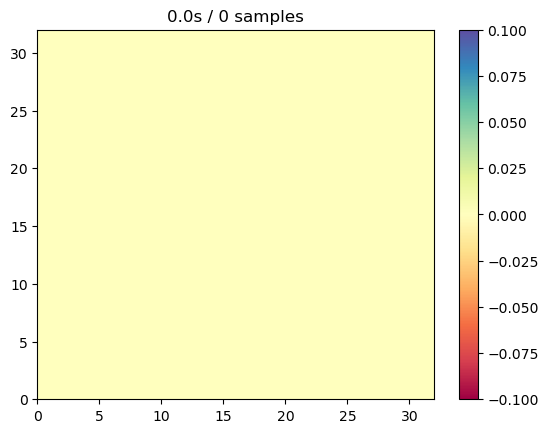

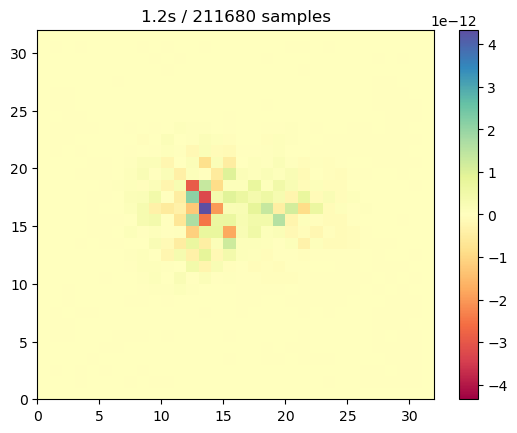

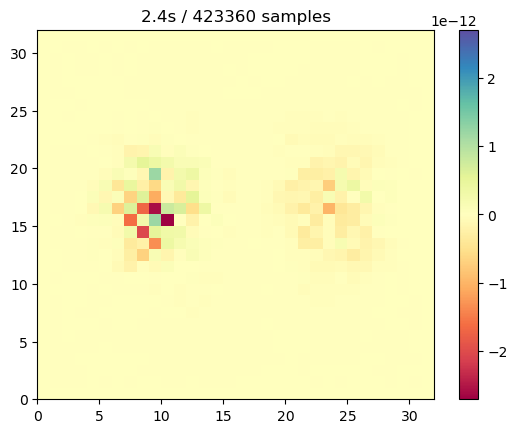

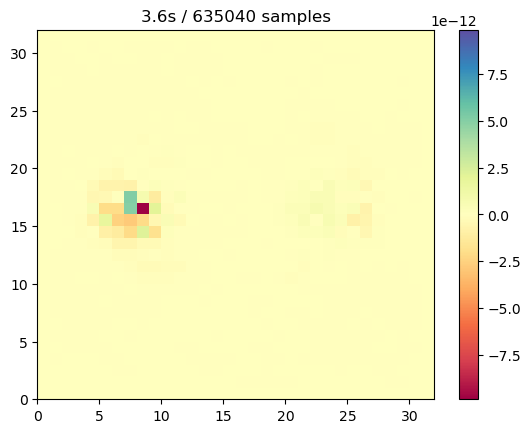

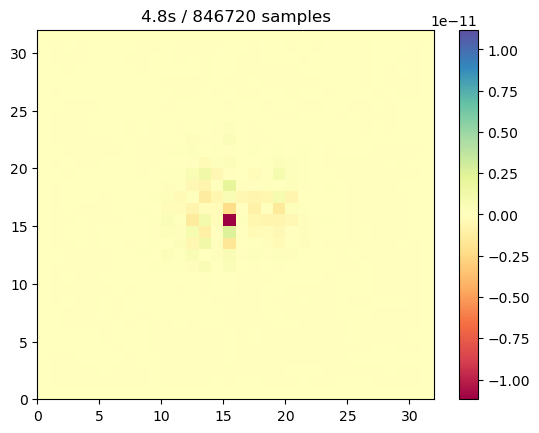

In [81]:
deflections = np.zeros((m, m))
speeds = np.zeros((m, m), dtype=np.float64)
forces = np.zeros((m, m), dtype=np.float64)

# speeds[tuple(excitement_point)] = 1

masses = np.empty((m, m))
data = frames[0, ::spatial_step, ::spatial_step]
last_data = frames[0, ::spatial_step, ::spatial_step]


audio = np.empty(num_simulated_steps)

for sample in range(num_simulated_steps):
    
    simulation_index = int(sample / sample_rate * sim_fps)
    last_data = data
    #data = get_interpolated(frames, [sample / sample_rate * fps])
    data = frames[simulation_index, ::spatial_step, ::spatial_step]
    #data = frames[0, ::spatial_step, ::spatial_step] # just first frame
    #data = frames[int(2.4 * sim_fps), ::spatial_step, ::spatial_step] # second 2.4 after first gothrough
    #data = 1 * np.ones((m, m)) # static plate
    
    masses = min_mass + (max_mass - min_mass) * np.abs(data)
    
    # Internal cells interaction
    #'''
    forces = np.zeros((m, m), dtype=np.float64)
    # Springs 
    forces[1:  ,  :  ] += spring_strength * (deflections[:-1, :] - deflections[1:  , :]) # Bottom
    forces[ :-1,  :  ] += spring_strength * (deflections[1:  , :] - deflections[:-1, :]) # Top
    forces[ :  , 1:  ] += spring_strength * (deflections[:  , :-1] - deflections[:  , 1:]) # Left
    forces[ :  ,  :-1] += spring_strength * (deflections[:  , 1:] - deflections[:  , :-1]) # Right
    
    # Fixed points
    #forces[::n-1, ::n-1] = 0 # fixed corners
    forces[::m-1, :] = 0 # fixed top & bottom
    forces[:, ::m-1] = 0 # fixed sides
    
    '''
    # Springs compact
    forces[1:-1, 1:-1] = spring_amount * (deflections[:-2, 1:-1] + deflections[2:, 1:-1] +
                          deflections[1:-1, :-2] + deflections[1:-1, 2:] -
                          4 * deflections[1:-1, 1:-1])
    '''

    # Add noise
    # TODO: As force or directly at speeds?
    # Forces seems to be better
    difference = np.abs(data) - np.abs(last_data)
    # forces[1:-1, 1:-1] += np.where(difference > 0, difference, 0)[1:-1, 1:-1] * (2 * np.random.random((m-2, m-2)) - 1)
    forces[1:-1, 1:-1] += np.abs(difference)[1:-1, 1:-1] * (2 * np.random.random((m-2, m-2)) - 1)

    # Update speeds with forces, apply dampening
    speeds += forces / masses / sample_rate
    speeds *= 1 - dampening_per_sample #/ masses
    
    deflections += speeds / sample_rate

    audio[sample] = listening(scaling(deflections, data))

    #'''
    if sample % (sample_rate * sonification_duration // 5) == 0:
        scale = np.max(np.abs(scaling(deflections, data)))
        plt.pcolormesh(scaling(deflections, data), vmin=-scale, vmax=scale, cmap='Spectral')
        plt.colorbar()
        plt.title(f"{round(sample/sample_rate, 2) }s / {sample} samples")
        plt.show()
    #'''

In [82]:
fade = 0.005
if fade > 0:
    fade_samples = int(sample_rate * fade)
    audio[:fade_samples]  *= np.square(np.linspace(start=0, stop=1, num=fade_samples, endpoint=False))
    audio[-fade_samples:] *= np.square(np.linspace(start=1, stop=0, num=fade_samples, endpoint=False))
audio_filename = f'output/sonification_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.wav'
write(audio_filename, sample_rate, np.round((audio - np.average(audio)) / np.max(np.abs(audio - np.average(audio))) * 32767).astype(np.int16))
print(f"Sonification saved as {audio_filename}")
Audio(audio, rate=sample_rate)

Sonification saved as output/sonification_2024_04_23-12_03_06.wav


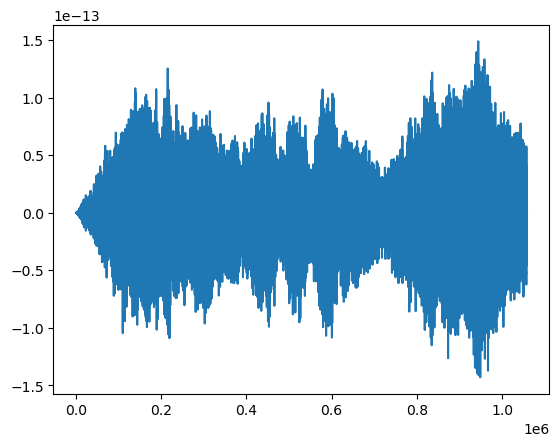

In [83]:
plt.plot(audio)

# Combine Audio & Video

In [84]:
combined_filename = f'output/combination_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'

# Construct the ffmpeg command to combine video and audio
ffmpeg_command = [
    'ffmpeg',
    '-i', video_filename,   # Input video file
    '-i', audio_filename,   # Input audio file
    '-c:v', 'copy',         # Copy the video stream
    '-c:a', 'aac',          # Encode the audio to AAC (necessary for some formats)
    '-shortest',            # Finish encoding when the shortest input stream ends
    combined_filename         # Output file
]

# Execute the command
subprocess.run(ffmpeg_command)

ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enab

CompletedProcess(args=['ffmpeg', '-i', 'output/simulation_2024_04_23-10_56_05.mp4', '-i', 'output/sonification_2024_04_23-12_03_06.wav', '-c:v', 'copy', '-c:a', 'aac', '-shortest', 'output/combination_2024_04_23-12_03_07.mp4'], returncode=0)